In [1]:
## TODO: calculate dimensionality reduction scoring methods

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np
import pandas as pd
import scipy.linalg as LA
import scipy.sparse as sps
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from utils import (fcps_reader, FCPSDataset, ImageMatDataset,
                   AutoEncoder, LLE, SparseLLE, Trainer, LambdaScheduler)

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap

from umap import UMAP

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm

# animation
from matplotlib import animation
from celluloid import Camera

# visualisation of the weights matrix
import r1svd
# %matplotlib notebook

In [4]:
def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

cmap = plt.cm.Spectral

## Reading the datasets

In [5]:
fcps_datasets = ['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

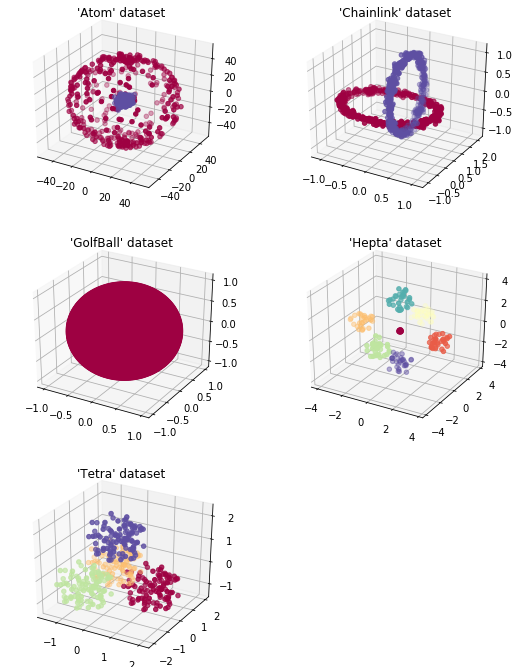

In [6]:
fig = plt.figure(figsize=(9,12))
for i, name in enumerate(fcps_datasets):
    data = fcps_reader(name)
    ax = fig.add_subplot(3,2,i+1, projection='3d')
    ax.scatter(data.x1, data.x2, data.x3, c=data.y, cmap=cmap)
    ax.set_title(f"{name!r} dataset")

In [7]:
data = fcps_reader('Hepta')
data.head()

,x1,x2,x3,y
0,,,,
1,-0.063274,0.027734,0.022683,1
2,-0.000731,0.048211,0.069198,1
3,-0.060767,-0.009080,0.053085,1
4,0.013252,-0.011876,0.055324,1
5,-0.054508,-0.003813,0.001738,1


In [8]:
data.y.value_counts().sort_index()

1    32
2    30
3    30
4    30
5    30
6    30
7    30
Name: y, dtype: int64

In [9]:
X = data.iloc[:, :-1].values
y = data.y

In [10]:
n_neighbors=9

## Dimensionality reduction methods

In [11]:
%%time
pca_embed = PCA(n_components=2).fit_transform(X)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 890 µs


In [12]:
%%time
lle_embed = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 31.2 ms, sys: 15.6 ms, total: 46.9 ms
Wall time: 23.6 ms


In [13]:
%%time
isomap_embed = Isomap(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 14.9 ms


In [14]:
%%time
mds_embed = MDS(n_components=2).fit_transform(X)

CPU times: user 234 ms, sys: 15.6 ms, total: 250 ms
Wall time: 232 ms


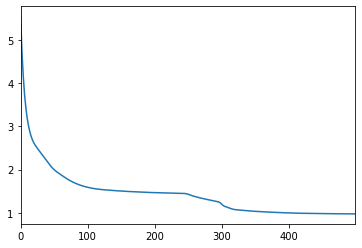

In [15]:
num_epochs = 500

ae = AutoEncoder([3,3,2])

inputs = torch.tensor(X, dtype=torch.float)
def train_ae(ae, inputs, num_epochs=50):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=.01, weight_decay=1e-5)
    
    losses = []
    for epoch in range(num_epochs):
        # ===================forward=====================
        enc, dec = ae(inputs)
        loss = criterion(dec, inputs)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

losses = train_ae(ae, inputs, num_epochs)
pd.Series(losses).plot()

In [16]:
with torch.no_grad():
    ae_embed = ae.encode(inputs).numpy()

### Plotting the results of the dimensionality reduction methods

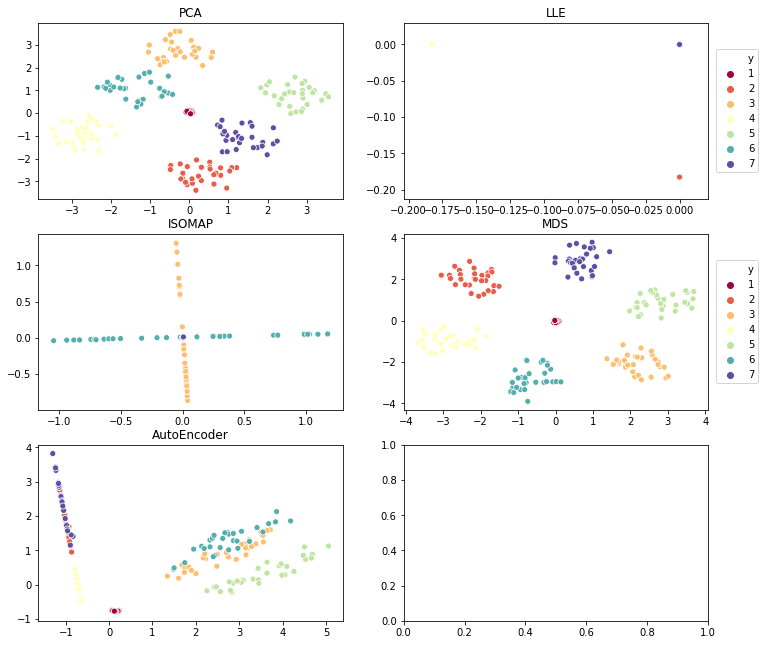

In [17]:
dimred = [("PCA", pca_embed), ("LLE", lle_embed), ("ISOMAP", isomap_embed),
          ("MDS", mds_embed), ("AutoEncoder", ae_embed)]
ncol = 2
fig, axs = plt.subplots(3, ncol, figsize=(12,11))

for i, (ax, (redname, redvals)) in enumerate(zip(axs.flat, dimred), start=1):
    sns.scatterplot(redvals[:, 0], redvals[:, 1], hue=y, ax=ax, palette=cmap, legend='full' if i%ncol==0 else None)
    ax.set_title(redname)
    if i%ncol==0:
        ax.legend(loc='center left', bbox_to_anchor=(1.01,.5))

### LLE implementation

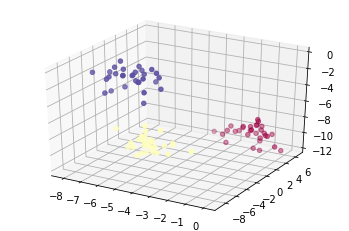

In [18]:
from sklearn.datasets import make_blobs
X_t, y_t = make_blobs(n_samples=90, n_features=3, centers=3, random_state=1)

ax = plt.axes(projection='3d')

ax.scatter(X_t[:,0], X_t[:,1], X_t[:,2], c=y_t, cmap=cmap)

In [19]:
n_neigh = 31

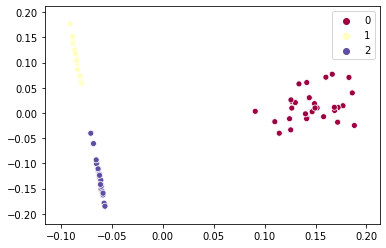

In [20]:
lleX = LocallyLinearEmbedding(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(lleX[:,0], lleX[:,1],hue=y_t, palette=cmap)

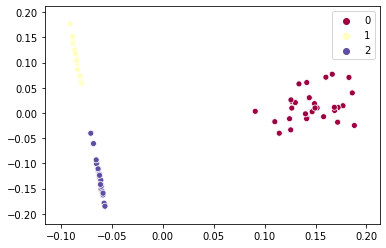

In [21]:
S, mylleX = LLE(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(mylleX[:,0], mylleX[:,1],hue=y_t, palette=cmap)

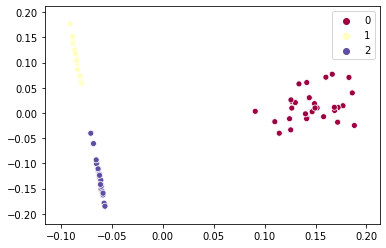

In [22]:
S, splleX = SparseLLE(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(splleX[:,0], splleX[:,1],hue=y_t, palette=cmap)

In [23]:
from sklearn.preprocessing import StandardScaler
# from scipy import stats

def compare_my_lle(normal, sparse):
    nrm = StandardScaler().fit_transform(normal)
    sprs = StandardScaler().fit_transform(sparse)
    for rot in [[1,1],[-1,1],[1,-1],[-1,-1]]:
        if np.allclose(nrm * rot, sprs):
            return True, nrm
    return False, nrm

# def compare_cor(normal, sparse):
#     return stats.pearsonr(normal[:,0], normal[:,1]), stats.pearsonr(sparse[:,0], sparse[:,1])

# compare_cor(mylleX, splleX)
same, scaled = compare_my_lle(mylleX, splleX)
print(same)
# # sns.scatterplot(scaled[:,0], scaled[:,1],hue=y_t, palette='Set1')

True


In [24]:
def loss(X, encoded, decoded, S, l):
    """Computes the autoencoder loss
    loss = ||X - decoded||^2 + l * ||encoded - S*encoded||^2
    the autoencoder should keep as much information while also
    keeping the neighborhoods as separate as possible // could be better phrased
    """
    sim = X - decoded  # how similar the result is to the input
    if l == 0:
        return (sim ** 2).sum()

    sep = encoded - S @ encoded  # how well separated the embedding is
    return (sim ** 2).sum() + l * (sep ** 2).sum()

In [25]:
fcps_datasets

['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

In [26]:
# %%prun -s time -l 20
# train = fcps_reader(fcps_datasets[-2])
# X_train = train.iloc[:, :-1].values
# y_train = train.y.values

X_train = X_t
y_train = y_t 

# mat = loadmat('../input/COIL20.mat')
# X_train = mat['fea']
# y_train = mat['gnd'].ravel()

# idx = np.arange(y_train.shape[0])
# np.random.shuffle(idx)
# X_train = X_train[idx, :]
# y_train = y_train[idx]

n_neigh = 20
inputs = torch.tensor(X_train, dtype=torch.float)
num_epochs = 50

In [27]:
# print(X_train.shape, y_train.shape)

ae = AutoEncoder([3,3,2])
# ae = AutoEncoder([1024, 256, 64, 16, 2])

optimizer = torch.optim.Adam(ae.parameters(), lr=.001, weight_decay=0) #1e-5)

losses = []
fig, ax = plt.subplots()
camera = Camera(fig)
r = r1svd.RankOneSvd()
for epoch in tqdm(range(num_epochs)):
    # encode
    enc, dec = ae(inputs)
    # compute
    X_enc = enc.detach().numpy()
    S, _ = LLE(n_neigh, X_enc.shape[1]).fit_transform(X_enc)
    
#     ax.spy(r.fit_transform(np.abs(S)))
#     ax.spy(np.abs(S))
    sns.scatterplot(X_enc[:,0], X_enc[:,1],hue=y_train, palette=cmap, ax=ax, legend=False)
    camera.snap()
    
    cost = loss(inputs, enc, dec, torch.tensor(S, dtype=torch.float),
                l=.5 if epoch <= 5 else 0.5 + .1*(epoch - num_epochs))

    losses.append(cost.item())
    
    # update autoencoder weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

plt.close(fig)
# losses = train_ae(ae, inputs, 50)

100%|██████████| 50/50 [00:01<00:00, 30.60it/s]


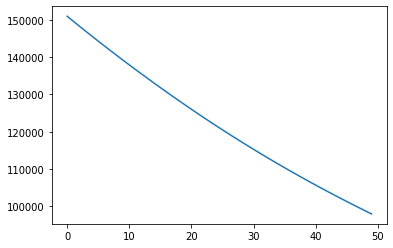

In [28]:
plt.plot(losses)

In [29]:
camera.animate(interval=500)

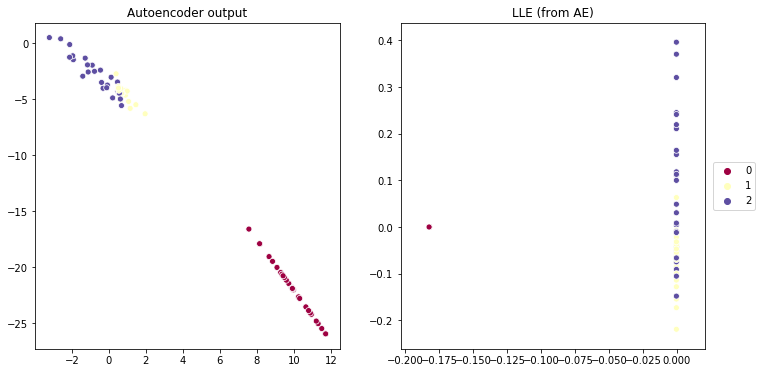

In [30]:
with torch.no_grad():
    ae_lle_embed = ae.encode(inputs).numpy()

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(ae_lle_embed[:,0], ae_lle_embed[:,1],hue=y_train, palette=cmap, ax=axs[0], legend=False)
axs[0].set_title('Autoencoder output')

_, Y = LLE(n_neigh, ae_lle_embed.shape[1]).fit_transform(ae_lle_embed)
sns.scatterplot(Y[:,0], Y[:,1],hue=y_train, palette=cmap, ax=axs[1], legend='full')
axs[1].set_title('LLE (from AE)')
axs[1].legend(loc='center left', bbox_to_anchor=(1.01,.5))

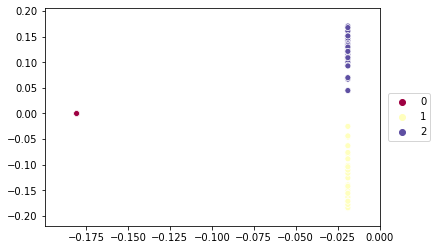

In [31]:
sklle_train = LocallyLinearEmbedding(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(sklle_train[:,0], sklle_train[:,1],hue=y_train, palette=cmap, legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

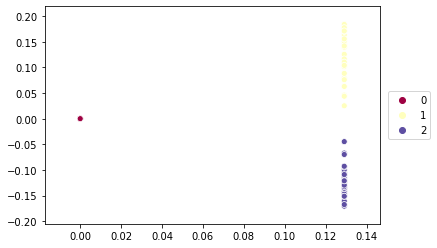

In [32]:
_, lle_train = LLE(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(lle_train[:,0], lle_train[:,1],hue=y_train, palette=cmap, legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

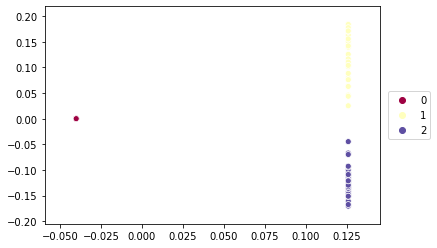

In [33]:
_, splle_train = SparseLLE(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(splle_train[:,0], splle_train[:,1],hue=y_train, palette=cmap, legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


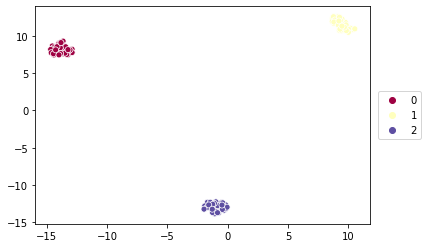

In [34]:
X_umap = UMAP(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(X_umap[:,0], X_umap[:,1],hue=y_train, palette=cmap, legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [35]:
n_batch=2

In [36]:
atom = FCPSDataset('Atom')
atomloader = DataLoader(atom, batch_size=len(atom)//n_batch,
                        shuffle=True, num_workers=0)

chainlink = FCPSDataset('Chainlink')
chainlinkloader = DataLoader(chainlink, batch_size=len(chainlink)//n_batch,
                        shuffle=True, num_workers=0)

golfball = FCPSDataset('GolfBall')
golfballloader = DataLoader(golfball, batch_size=len(golfball), shuffle=True, num_workers=0)

hepta = FCPSDataset('Hepta')
heptaloader = DataLoader(hepta, batch_size=len(hepta)//n_batch,
                        shuffle=True, num_workers=0)

tetra = FCPSDataset('Tetra')
tetraloader = DataLoader(tetra, batch_size=len(tetra)//n_batch,
                        shuffle=True, num_workers=0)

In [37]:
coil20 = ImageMatDataset('COIL20')
coil20loader = torch.utils.data.DataLoader(coil20, batch_size=len(coil20)//n_batch,
                                          shuffle=True, num_workers=0)

coil100 = ImageMatDataset('COIL100')
coil100loader = torch.utils.data.DataLoader(coil100, batch_size=1000,
                                          shuffle=True, num_workers=0)

mnist = ImageMatDataset('MNIST')
mnistloader = torch.utils.data.DataLoader(mnist, batch_size=1000,
                                          shuffle=True, num_workers=0)

orl = ImageMatDataset('ORL')
orlloader = torch.utils.data.DataLoader(orl, batch_size=len(orl)//n_batch,
                                          shuffle=True, num_workers=0)

usps = ImageMatDataset('USPS')
uspsloader = torch.utils.data.DataLoader(usps, batch_size=1000,
                                          shuffle=True, num_workers=0)

yale = ImageMatDataset('Yale')
yaleloader = torch.utils.data.DataLoader(yale, batch_size=len(yale),
                                          shuffle=True, num_workers=0)

In [38]:
training_params = {
    'atom': {
        'dataset': atom,
        'dataloader': atomloader,
        'ae_layers': [3,3,2],
        'learning_rate': .1,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
                                            method='sigmoid', c0=2,c1=.8),
        'lambda_step': 'iter',
    },
    'chainlink': {
        'dataset': chainlink,
        'dataloader': chainlinkloader,
        'ae_layers': [3,3,2],
        'learning_rate': .1,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
                                            method='sigmoid',c0=2,c1=.8),
        'lambda_step': 'iter',
    },
    'golfball': {
        'dataset': golfball,
        'dataloader': golfballloader,
        'ae_layers': [3,3,2],
        'learning_rate': .1,
        'n_epochs': 50,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
                                            method='sigmoid',c0=2,c1=.8),
        'lambda_step': 'iter',
    },
    'hepta': {
        'dataset': hepta,
        'dataloader': heptaloader,
        'ae_layers': [3,3,2],
        'learning_rate': .1,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
                                            method='sigmoid',c0=2,c1=.8),
        'lambda_step': 'iter',
    },
    'tetra': {
        'dataset': tetra,
        'dataloader': tetraloader,
        'ae_layers': [3,3,2],
        'learning_rate': .1,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
                                            method='sigmoid',c0=2,c1=.8),
        'lambda_step': 'iter',
    },
    # image datasets
    'coil20': {
        'dataset': coil20,
        'dataloader': coil20loader,
        'ae_layers': [1024, 512, 256, 64, 16, 2],
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'coil100': {
        'dataset': coil100,
        'dataloader': coil100loader,
        'ae_layers': [1024, 512, 256, 64, 16, 2],
        'learning_rate': .001,
        'n_epochs': 50,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'mnist': {
        'dataset': mnist,
        'dataloader': mnistloader,
        'ae_layers': [784, 512, 256, 64, 16, 2],
        'learning_rate': .001,
        'n_epochs': 50,
        'sparse_lle': False,
        'predict_lle': False,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'orl': {
        'dataset': orl,
        'dataloader': orlloader,
        'ae_layers': [1024, 512,64,32,2],
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'usps': {
        'dataset': usps,
        'dataloader': uspsloader,
        'ae_layers': [256, 128, 64, 8, 2],
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'yale': {
        'dataset': yale,
        'dataloader': yaleloader,
        'ae_layers': [1024, 512, 256, 64, 16, 2],
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    
}

In [39]:
# %%prun -s time
def train_model(ae_layers, dataset, dataloader,
                learning_rate=.001, n_epochs=50,
                sparse_lle=False, predict_lle=True, n_neighbors=9,
                lambda_scheduler=None, lambda_step='batch'):
    
    labels = dataset.y.numpy().ravel()
    n_classes = len(np.unique(labels))
    
    net = AutoEncoder(ae_layers)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    trainer = Trainer(net, dataloader, dataset, optimizer,
                      n_epochs=n_epochs, sparse_lle=sparse_lle, n_neighbors=n_neighbors,
                      lambda_scheduler=lambda_scheduler, lambda_step=lambda_step)
    
    trainer.train_model(track_Y=True)

    results = trainer.transform(lle=predict_lle)
    net_embed = results['X_ae']
    Y = results['Y']
    
    ncols = 3
    nrows = 2
    fig, axs = plt.subplots(nrows,ncols, figsize=(ncols*5,nrows*6))
    
    n_batch = labels.shape[0] // dataloader.batch_size + (1 if labels.shape[0] % dataloader.batch_size != 0 else 0)
    
    (pd.Series(trainer.losses)
     .rolling(n_batch).mean() # smooth the batch losses
     .plot(ax=axs[0,0]))
    axs[0,0].set_title("Plot of the average loss per batch")
    
    
    sns.scatterplot(net_embed[:,0], net_embed[:,1], hue=labels, palette=cmap, ax=axs[0,1], legend=False)
    axs[0,1].set_title('Autoencoder output')
    
    if Y is not None:
        sns.scatterplot(Y[:,0], Y[:,1],hue=labels, palette=cmap, ax=axs[0,2], legend='full' if n_classes <= 20 else 'brief')
        axs[0,2].set_title('LLE (from AE)')
        axs[0,2].legend(loc='center left', bbox_to_anchor=(1.01,.5))
    else:
        axs[0,2].set_title('LLE (from AE) - not computed')
    
    X = dataset.X.detach().numpy()
    y = dataset.y.detach().numpy().ravel()
    x_pca = PCA().fit_transform(X)
    sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=labels, palette=cmap, ax=axs[1,0], legend=False)
    axs[1,0].set_title('PCA')
    
    x_umap = UMAP(n_neighbors=n_neighbors).fit_transform(X)
    sns.scatterplot(x_umap[:,0], x_umap[:,1], hue=labels, palette=cmap, ax=axs[1,1], legend=False)
    axs[1,1].set_title('UMAP')
    
    
    if Y is not None:
        _, x_lle = LLE(n_neighbors=n_neighbors).fit_transform(X)
        sns.scatterplot(x_lle[:,0], x_lle[:,1], hue=labels, palette=cmap, ax=axs[1,2], legend='full' if n_classes <= 20 else 'brief')
        axs[1,2].legend(loc='center left', bbox_to_anchor=(1.01,.5))
        axs[1,2].set_title('LLE')
    else:
        axs[0,2].set_title('LLE - not computed')
        x_lle = None

    return fig, trainer

loss: 248923.141: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


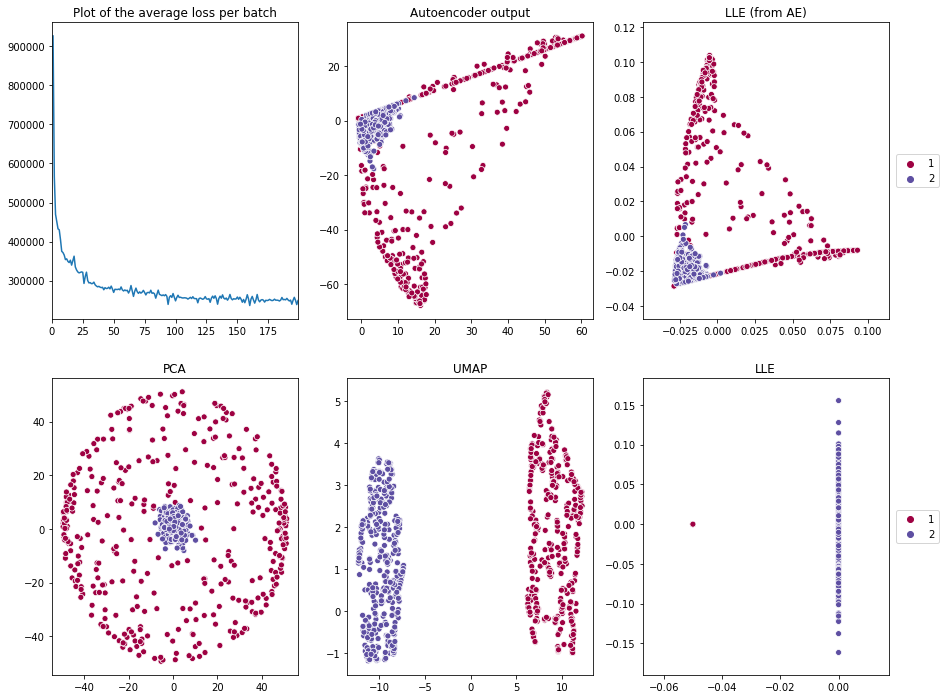

In [40]:
fig_atom, trainer_atom = train_model(**training_params['atom'])

In [41]:
# trainer_atom.y_camera_.animate(interval=200)

loss: 623.005: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


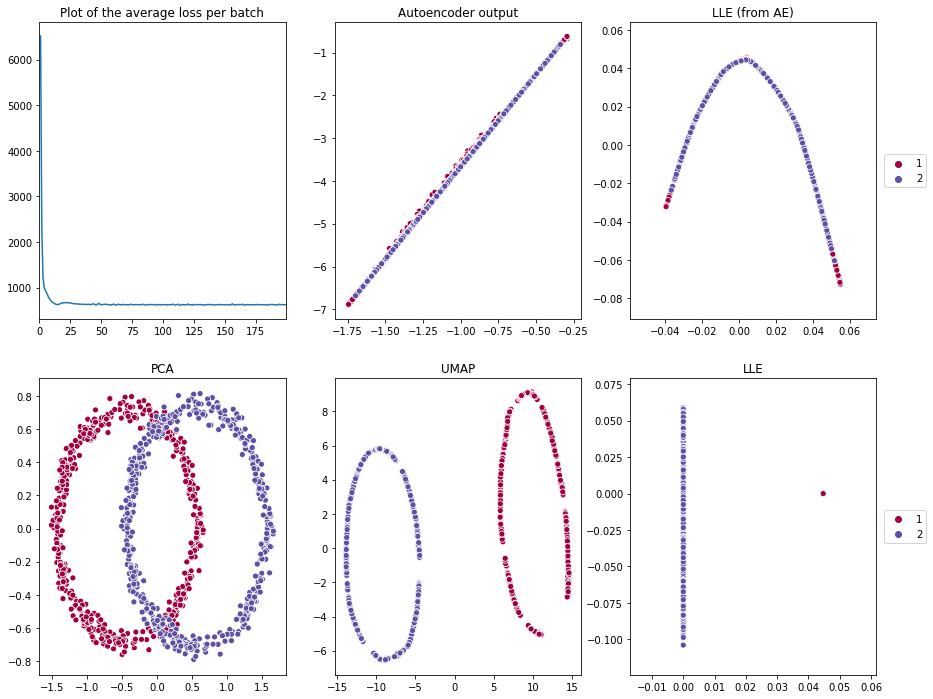

In [42]:
fig_chainlink, trainer_chainlink = train_model(**training_params['chainlink'])

In [43]:
trainer_chainlink.y_camera_.animate(interval=200)

In [44]:
# fig_golfball, trainer_golfball = train_model(**training_params['golfball'])

loss: 115.365: 100%|██████████| 100/100 [00:05<00:00, 17.15it/s]
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


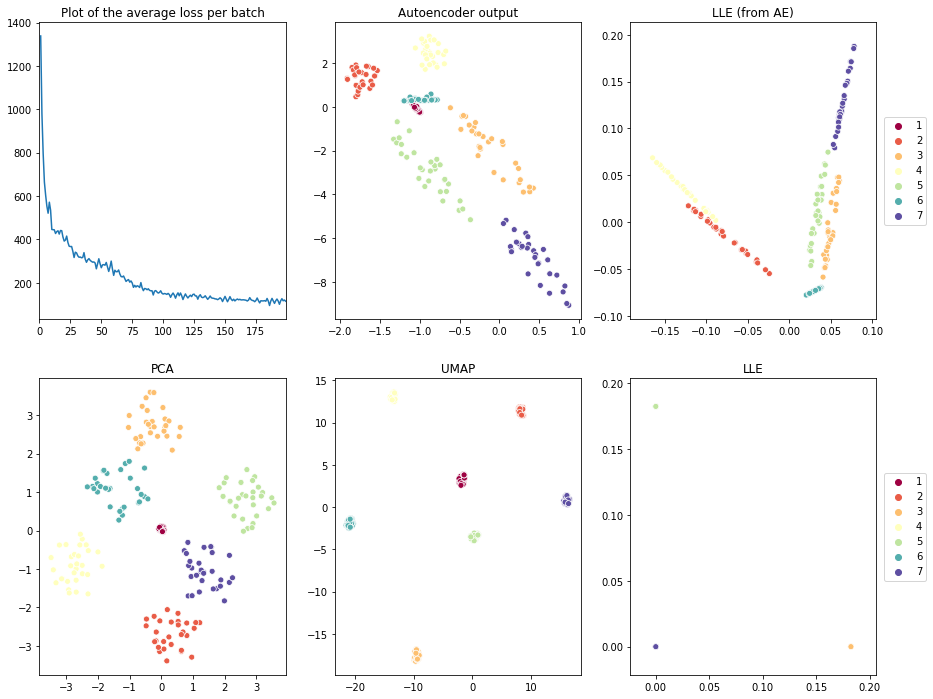

In [45]:
fig_hepta, trainer_hepta = train_model(**training_params['hepta'])

In [46]:
# trainer_hepta.y_camera_.animate(interval=200)

loss: 181.246: 100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


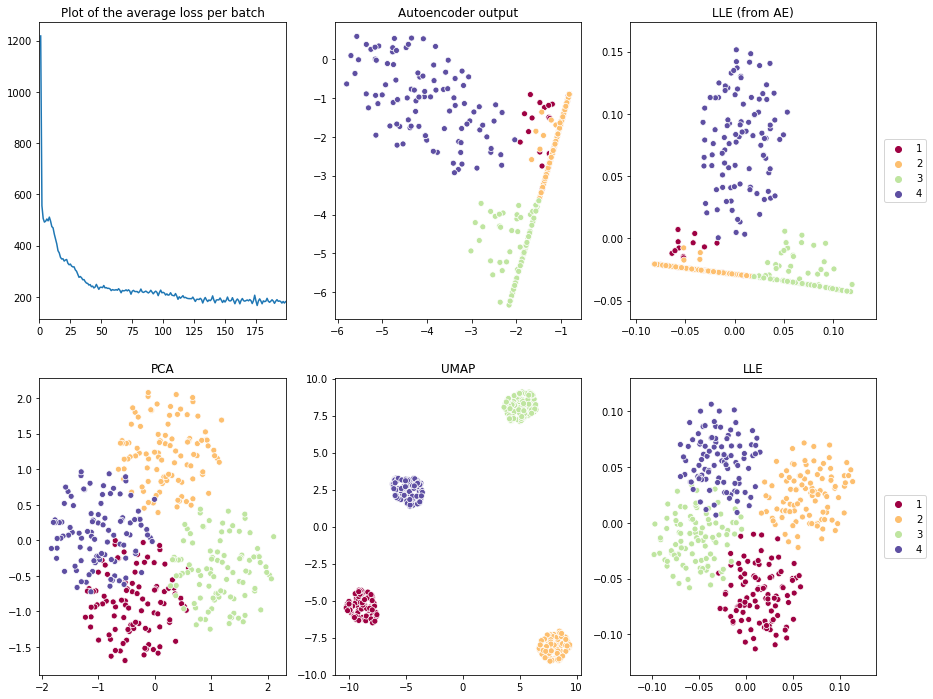

In [47]:
fig_tetra, trainer_tetra = train_model(**training_params['tetra'])

In [48]:
# trainer_tetra.y_camera_.animate(interval=200)

loss: 310508288.000: 100%|██████████| 100/100 [00:07<00:00, 14.26it/s]


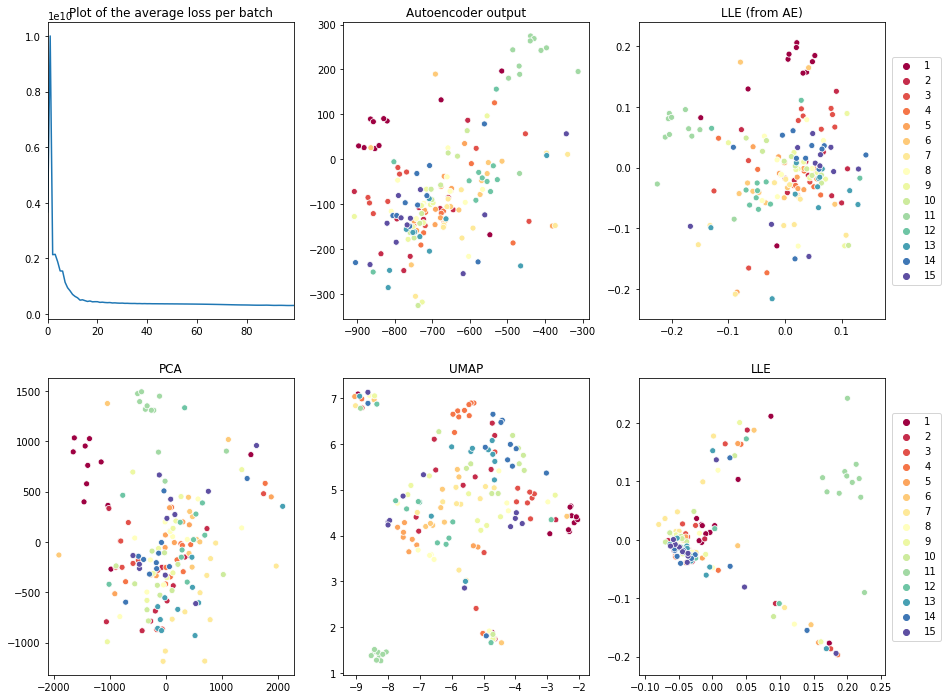

In [49]:
fig_yale, trainer_yale = train_model(**training_params['yale'])

In [50]:
# trainer_yale.y_camera_.animate(interval=200)

loss: 149993136.000: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


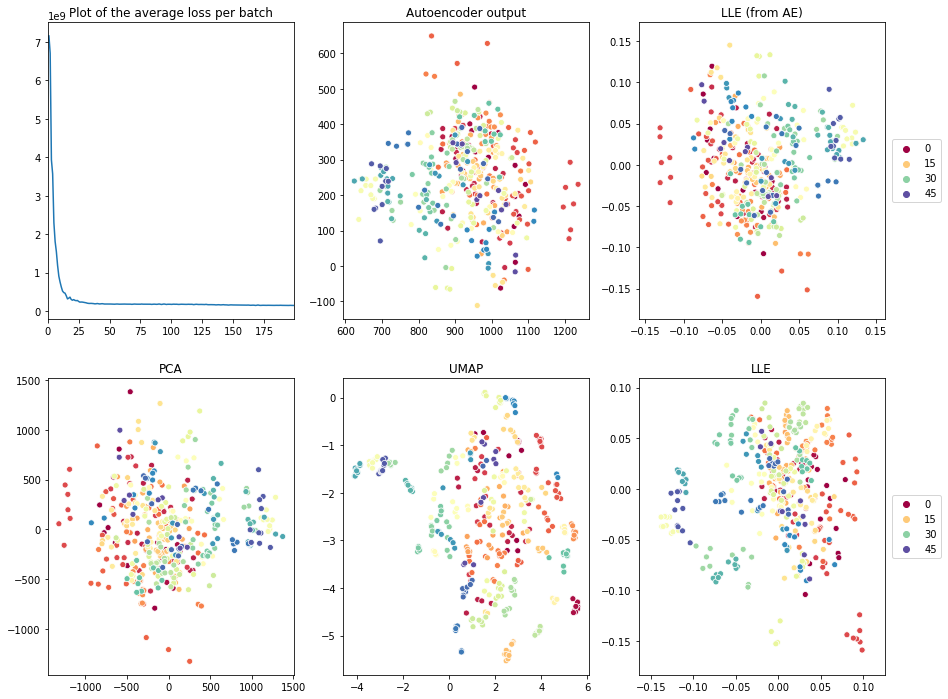

In [51]:
fig_orl, trainer_orl = train_model(**training_params['orl'])

In [52]:
# trainer_orl.y_camera_.animate(interval=200)

loss: 19997.591: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


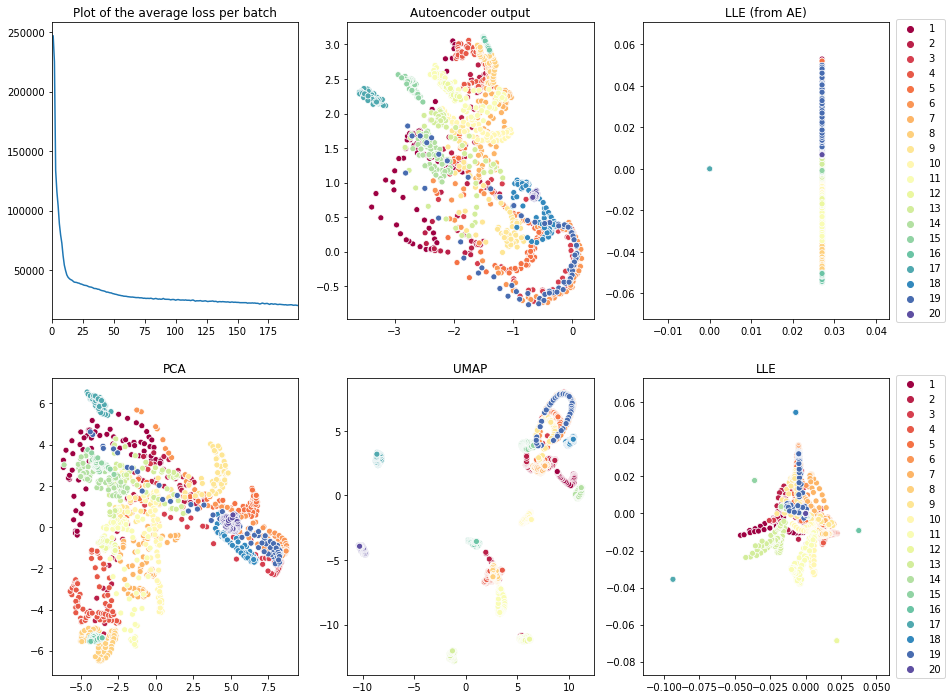

In [53]:
fig_coil20, trainer_coil20 = train_model(**training_params['coil20'])

In [54]:
# trainer_coil20.y_camera_.animate(interval=200)

loss: 992663260.000: 100%|██████████| 50/50 [06:50<00:00,  8.20s/it] 
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../python-envs/mlds/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel

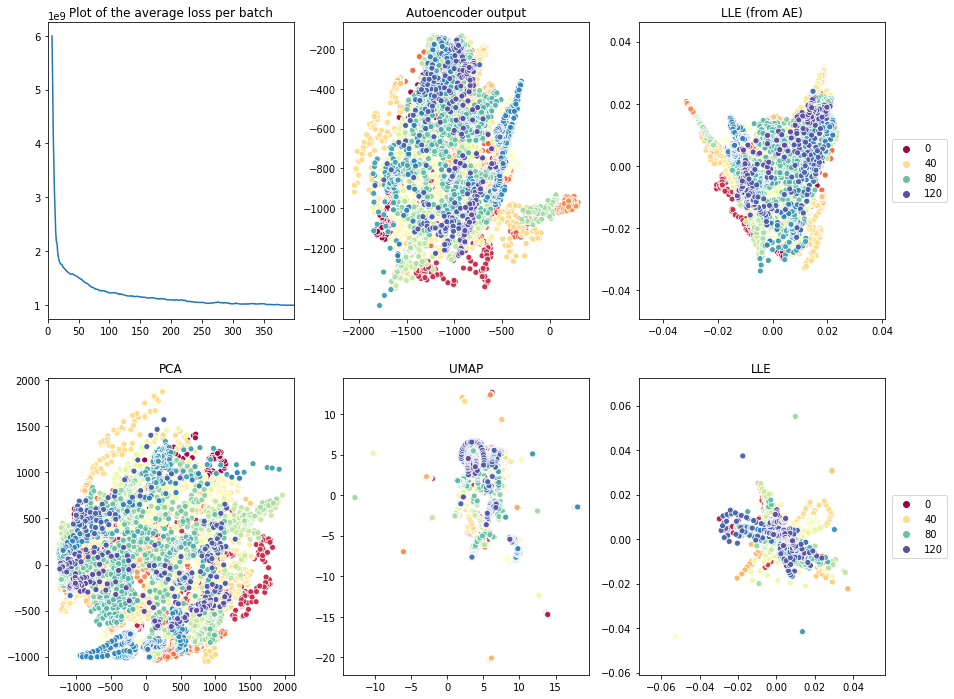

In [55]:
fig_coil100, trainer_coil100 = train_model(**training_params['coil100'])

In [56]:
# trainer_coil100.y_camera_.animate(interval=200)

loss: 26822.013: 100%|██████████| 100/100 [15:46<00:00,  9.46s/it]
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../python-envs/mlds/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


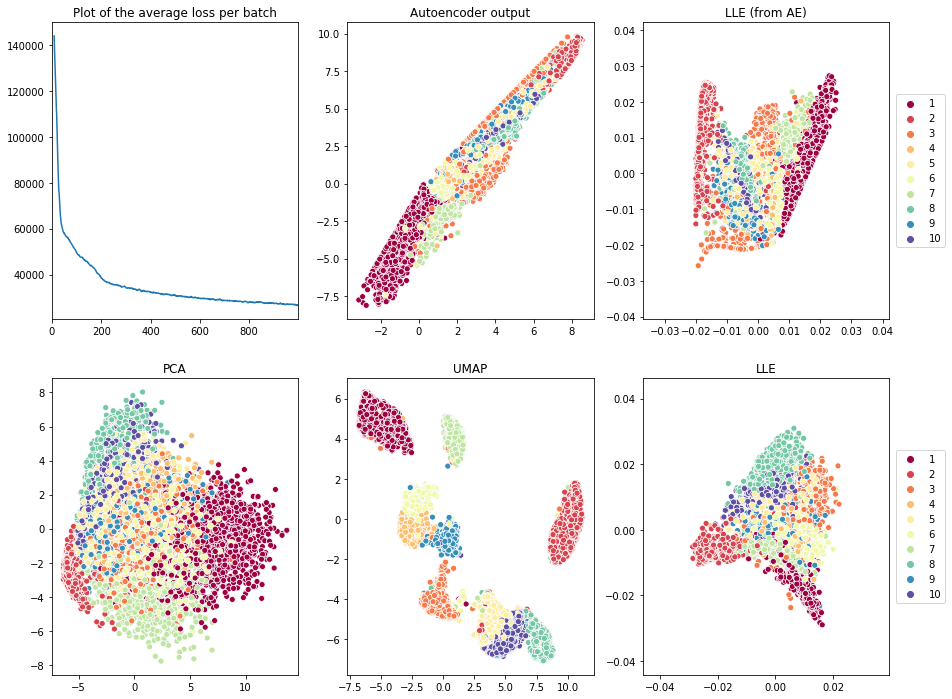

In [57]:
fig_usps, trainer_usps = train_model(**training_params['usps'])

In [58]:
# trainer_usps.y_camera_.animate(interval=200)

loss: 1965518378.057: 100%|██████████| 50/50 [1:10:06<00:00, 84.14s/it]
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../python-envs/mlds/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


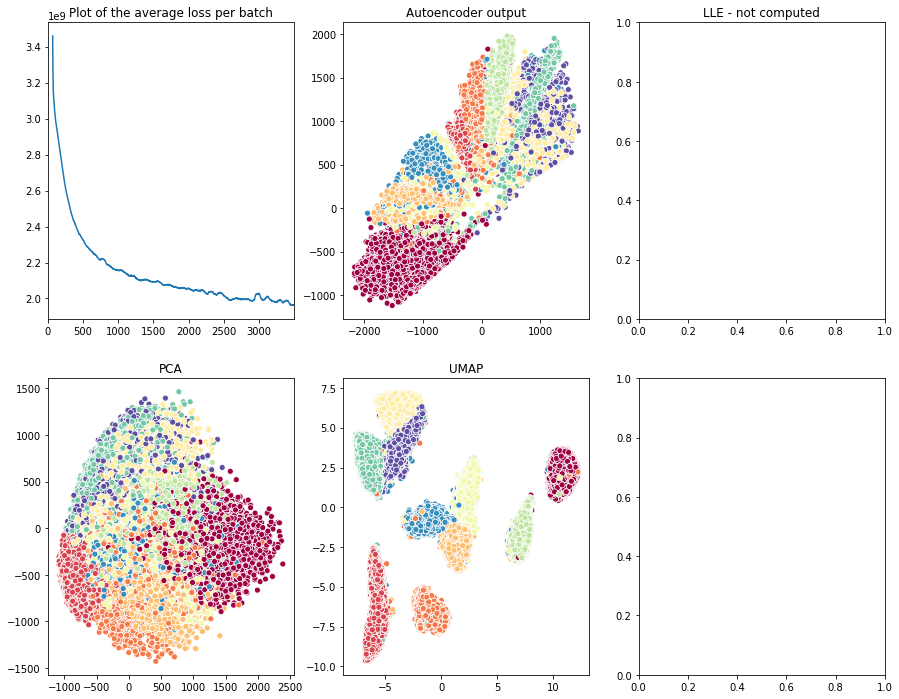

In [59]:
fig_mnist, trainer_mnist = train_model(**training_params['mnist'])

In [60]:
# trainer_mnist.y_camera_.animate(interval=200)